In [ ]:
import BioSimSpace as bss
import glob
import BioSimSpace._Exceptions
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

: 

In [2]:
_K_B = scipy.constants.Boltzmann
_TEMPERATURE = 310.15
_N_A = scipy.constants.Avogadro


def inhibition_to_ddg(ki_a: float, ki_b: float) -> float:
    """
    convert experimental Ki values to binding free-energy difference
    :param ki_a: experimental Ki of ligand 1
    :param ki_b: experimental Ki of ligand 1
    :return: experimental RBFE value
    """
    ic50_a = 2 * ki_a
    ic50_b = 2 * ki_b

    return (_K_B * _N_A * _TEMPERATURE / 4184) * np.log(ic50_b / ic50_a)


def get_experimental_error(error_a, ki_a, error_b, ki_b):
    fraction = ki_b / ki_a
    fraction_error = fraction * np.sqrt((error_b / ki_b) ** 2 + (error_a / ki_a) ** 2)
    return (_K_B * _TEMPERATURE * fraction_error / fraction) * _N_A / 4184

In [3]:
somd_path = "/home/jguven/projects/metalloenzymes/starmap/outputs/with_min/SOMD_"
repeats = ["1", "2", "3"]

In [4]:
analysis_path = "/home/jguven/projects/metalloenzymes/starmap/afe/"

In [5]:
unbound_repeats, bound_repeats = [], []
unbound_om_repeats, bound_om_repeats = [], []
for repeat in repeats:
    somd_folder = somd_path + repeat + "/"
    analysis_file = analysis_path + "somd_repeat_analysis_" + repeat + ".txt"
    paths = sorted(glob.glob(somd_folder + "*/"))
    unbound_pmfs, bound_pmfs = [], []
    unbound_oms, bound_oms = [], []
    with open(analysis_file, "w") as file:   
        for path in paths:
            ligand = path.split("/")[-2]
            unbound_directory = somd_folder + ligand + "/unbound/"
            bound_directory = somd_folder + ligand + "/bound/"     
            transformation = path.split("/")[-2]         
            try: 
                pmf_unbound, overlap_matrix_unbound = bss.FreeEnergy.Relative.analyse(unbound_directory)
                pmf_bound, overlap_matrix_bound = bss.FreeEnergy.Relative.analyse(bound_directory)
                free_energy_difference, free_energy_error = bss.FreeEnergy.Relative.difference(pmf_bound, pmf_unbound)
                file.write(transformation + "\n")
                file.write(f"{free_energy_difference} \u00B1 {free_energy_error} \n")   
            except BioSimSpace._Exceptions.AnalysisError as e:
                print(e)
            except IndexError as e:
                print(str(e)+"\n")
            except ValueError as e:
                print(str(e)+"\n")


SOMD free-energy analysis failed!
SOMD free-energy analysis failed!
SOMD free-energy analysis failed!


In [6]:
repeat_differences = []
repeat_errors = []
for repeat in repeats:
    print(repeat)
    somd_folder = somd_path + repeat + "/"
    analysis_file = analysis_path + "somd_repeat_analysis_" + repeat + ".txt"
    with open(analysis_file, "r") as file:
        lines = file.readlines()
    results = [line for line in lines[1:len(lines):2]]
    differences = []
    errors = []
    for result in results:
        split_results = result.split("±")
        free_energy_difference = float(split_results[0].replace("kcal/mol", ""))
        error = float(split_results[1].replace("kcal/mol", ""))
        differences.append(free_energy_difference)
        errors.append(error)
    repeat_differences.append(np.array(differences))
    repeat_errors.append(np.array(errors))
repeat_differences = np.array(repeat_differences)
repeat_errors = np.array(repeat_errors)

1
2
3


In [7]:
repeat_differences = np.transpose(repeat_differences)
repeat_errors = np.transpose(repeat_errors)

In [9]:
repeat_differences


array([[-0.2248, -0.3306, -0.4692],
       [-0.5161, -0.1881, -0.0029],
       [-0.4226, -0.3949, -0.1629],
       [-0.3926, -0.0538, -0.1919],
       [ 0.3198,  0.3654,  0.769 ],
       [ 0.2285,  0.2955,  0.1359],
       [ 0.5272,  1.1799,  0.8957],
       [-1.1292, -0.7329, -0.6137],
       [-0.2323,  0.0155, -0.4164],
       [-0.4139, -0.3016, -0.2087],
       [-0.1104, -0.1496, -0.335 ],
       [-0.5708,  0.1671, -0.3531],
       [-0.4958, -0.5749, -0.039 ],
       [-0.0764, -0.1163,  0.0251]])

In [10]:
averages = np.mean(repeat_differences, axis=1)
experimental_file = pd.read_csv("../kpc2/afe/experimental_ki.txt")
experimental_ki, experimental_ki_error = experimental_file["K_i"], experimental_file["K_i_err"]
ligand_1 = experimental_ki[0]
ligand_1_error = experimental_ki_error[0]
experimental_free_energies = []
experimental_errors = []

perturbations = [line.strip() for line in lines[0:len(lines):2]]  
print(perturbations)
first_indices = []
second_indices = []
for line in perturbations:
    no_newline = line.strip("\n")
    lig_1 = no_newline.split("~")[0].replace("lig_", "")
    lig_2 = no_newline.split("~")[1].replace("lig_", "")  
    first_indices.append(int(lig_1) - 1)
    second_indices.append(int(lig_2) - 1)
print(second_indices)
for i in range(len(first_indices)):
    print(first_indices[i], second_indices[i])
experimental_free_energies = []
experimental_errors = []
for i in range(len(first_indices)):
    i_1, i_2 = first_indices[i], second_indices[i]
    experimental_free_energy = inhibition_to_ddg(experimental_ki[i_1], experimental_ki[i_2])
    # error_a, ki_a, error_b, ki_b
    experimental_error = get_experimental_error(experimental_ki_error[i_1], experimental_ki[i_1], experimental_ki_error[i_2], experimental_ki[i_2])
    experimental_free_energies.append(experimental_free_energy)
    experimental_errors.append(experimental_error)

['lig_1~lig_10', 'lig_1~lig_11', 'lig_1~lig_12', 'lig_1~lig_14', 'lig_1~lig_15', 'lig_1~lig_16', 'lig_1~lig_2', 'lig_1~lig_3', 'lig_1~lig_4', 'lig_1~lig_5', 'lig_1~lig_6', 'lig_1~lig_7', 'lig_1~lig_8', 'lig_1~lig_9']
[9, 10, 11, 13, 14, 15, 1, 2, 3, 4, 5, 6, 7, 8]
0 9
0 10
0 11
0 13
0 14
0 15
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8


Text(0, 0.5, '$\\Delta \\Delta$ G (kcal mol⁻¹)')

<>:44: DeprecationWarning: invalid escape sequence \D
<>:44: DeprecationWarning: invalid escape sequence \D
/tmp/ipykernel_2539695/479421597.py:44: DeprecationWarning: invalid escape sequence \D
  plt.ylabel("$\Delta \Delta$ G (kcal mol⁻¹)")


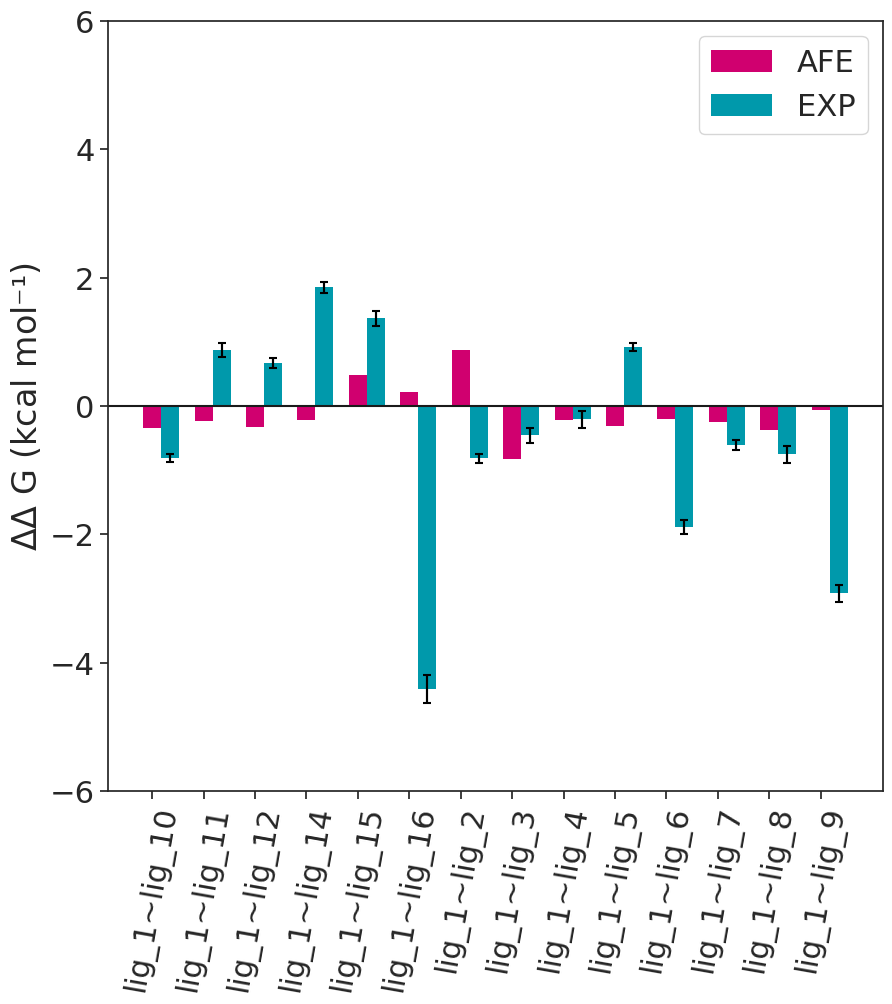

In [11]:
fig = plt.figure(figsize=(10, 10))
sns.set(context="notebook", palette="colorblind", style="ticks", font_scale=2)
x_label_locations = np.arange(len(averages))
bar_width = 0.35

plt.bar(x_label_locations - bar_width / 2,
        height=averages,
        width=bar_width,
        # yerr=standard_error_on_weighted_mean,
        label="AFE",
        color="#D0006F",
        linewidth=0)

# (_, caps, _) = plt.errorbar(x_label_locations - bar_width / 2,
#                             averages,
#                             color="black",
#                             yerr=standard_error_on_weighted_mean,
#                             capsize=3,
#                             linestyle="")

plt.bar(x_label_locations + bar_width / 2,
        height=experimental_free_energies,
        width=bar_width,
        yerr=experimental_errors,
        label="EXP",
        color="#0099AB",
        linewidth=0)

(_, caps, _) = plt.errorbar(x_label_locations + bar_width / 2,
                            experimental_free_energies,
                            color="black",
                            yerr=experimental_errors,
                            capsize=3,
                            linestyle="")

for cap in caps:
    cap.set_color("black")
    cap.set_markeredgewidth(1.5)
# plt.ylim(-55, -40)
plt.axhline(0, 0, 1, c="k")
plt.ylim(-6, 6)
plt.xticks(x_label_locations - bar_width / 2, perturbations, rotation=80, ha="center")
plt.legend()
plt.ylabel("$\Delta \Delta$ G (kcal mol⁻¹)")

In [66]:
repeat_errors


array([[0.1605, 0.1517, 0.1611],
       [0.1199, 0.1132, 0.1098],
       [0.1161, 0.1161, 0.1272],
       [0.1857, 0.1826, 0.1791],
       [0.1504, 0.1592, 0.1398],
       [0.0597, 0.1196, 0.1227],
       [0.1534, 0.1497, 0.1535],
       [0.2246, 0.2099, 0.2175],
       [0.0566, 0.1085, 0.1165],
       [0.17  , 0.1572, 0.1675],
       [0.1052, 0.1056, 0.1068],
       [0.2181, 0.2429, 0.2389],
       [0.0834, 0.2006, 0.177 ],
       [0.045 , 0.0578, 0.0576]])

In [67]:
f = lambda x: x ** -2
reciprocal_stds = f(repeat_errors)

In [68]:
avg_differences = np.average(repeat_differences, axis=1, weights=reciprocal_stds)

In [71]:
avg_differences

array([-0.34080888, -0.22043299, -0.33645628, -0.21051226,  0.50360937,
        0.22498193,  0.8727142 , -0.81672546, -0.21640066, -0.30679015,
       -0.19708592, -0.2766897 , -0.43289454, -0.05936137])

In [74]:
reciprocal_stds

array([[ 38.81949903,  43.45390779,  38.53087922],
       [ 69.56033002,  78.03818252,  82.94597563],
       [ 74.18832409,  74.18832409,  61.80530833],
       [ 28.99854398,  29.9915184 ,  31.17516985],
       [ 44.2083522 ,  39.45607434,  51.16649372],
       [280.57652865,  69.90973255,  66.42183578],
       [ 42.4961201 ,  44.62275698,  42.4407686 ],
       [ 19.82350735,  22.69734834,  21.13885586],
       [312.15273009,  84.94552868,  73.67975096],
       [ 34.60207612,  40.46643229,  35.64268211],
       [ 90.35839755,  89.6751607 ,  87.67130974],
       [ 21.02270852,  16.94903476,  17.52135547],
       [143.76987619,  24.85067231,  31.91930799],
       [493.82716049, 299.32591803, 301.40817901]])

In [75]:
sum_of_reciprocal_stds = np.sum(reciprocal_stds, axis=1)
standard_error_on_weighted_mean = np.sqrt(1/sum_of_reciprocal_stds)

In [76]:
standard_error_on_weighted_mean

array([0.0909827 , 0.06586014, 0.06897668, 0.10531263, 0.08612024,
       0.04897561, 0.08785473, 0.12533364, 0.04608843, 0.09503952,
       0.06111838, 0.13423956, 0.07061544, 0.03022595])

In [88]:
experimental_file = pd.read_csv("../kpc2/afe/experimental_ki.txt")
experimental_ki, experimental_ki_error = experimental_file["K_i"], experimental_file["K_i_err"]
ligand_1 = experimental_ki[0]
ligand_1_error = experimental_ki_error[0]
experimental_free_energies = []
experimental_errors = []

perturbations = [line.strip() for line in lines[0:len(lines):2]]  
print(perturbations)
first_indices = []
second_indices = []
for line in perturbations:
    no_newline = line.strip("\n")
    lig_1 = no_newline.split("~")[0].replace("lig_", "")
    lig_2 = no_newline.split("~")[1].replace("lig_", "")  
    first_indices.append(int(lig_1) - 1)
    second_indices.append(int(lig_2) - 1)
print(second_indices)
for i in range(len(first_indices)):
    print(first_indices[i], second_indices[i])
experimental_free_energies = []
experimental_errors = []
for i in range(len(first_indices)):
    i_1, i_2 = first_indices[i], second_indices[i]
    experimental_free_energy = inhibition_to_ddg(experimental_ki[i_1], experimental_ki[i_2])
    # error_a, ki_a, error_b, ki_b
    experimental_error = get_experimental_error(experimental_ki_error[i_1], experimental_ki[i_1], experimental_ki_error[i_2], experimental_ki[i_2])
    experimental_free_energies.append(experimental_free_energy)
    experimental_errors.append(experimental_error)
    


['lig_1~lig_10', 'lig_1~lig_11', 'lig_1~lig_12', 'lig_1~lig_14', 'lig_1~lig_15', 'lig_1~lig_16', 'lig_1~lig_2', 'lig_1~lig_3', 'lig_1~lig_4', 'lig_1~lig_5', 'lig_1~lig_6', 'lig_1~lig_7', 'lig_1~lig_8', 'lig_1~lig_9']
[9, 10, 11, 13, 14, 15, 1, 2, 3, 4, 5, 6, 7, 8]
0 9
0 10
0 11
0 13
0 14
0 15
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8


In [89]:
experimental_errors

[0.06339119807138811,
 0.11092329083847266,
 0.07827644557644327,
 0.09308425677984827,
 0.1198261186916253,
 0.2170558311359067,
 0.06619392216622669,
 0.1143014149681092,
 0.13201637266119665,
 0.059797331794967275,
 0.10406224515816033,
 0.08131752800823955,
 0.12996023347397595,
 0.12864329604231448]

In [90]:
experimental_free_energies

[-0.8068485447286646,
 0.873057234369901,
 0.671627032963703,
 1.8481713040559282,
 1.3674338567957676,
 -4.414869755776861,
 -0.8139037901191131,
 -0.45643289562892986,
 -0.20568714501253604,
 0.9217094390612374,
 -1.8820814044321212,
 -0.6062568262702405,
 -0.7532248890425166,
 -2.9187438532728036]

Text(0, 0.5, '$\\Delta \\Delta$ G (kcal mol⁻¹)')

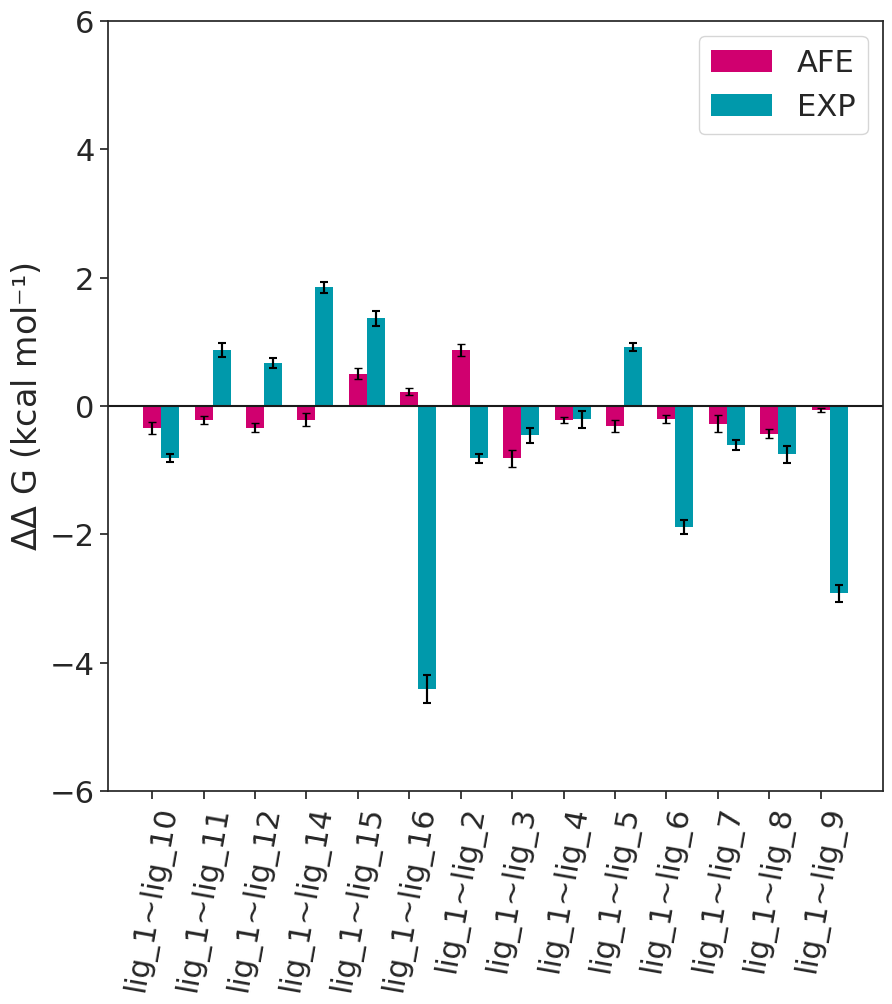

In [93]:
fig = plt.figure(figsize=(10, 10))
sns.set(context="notebook", palette="colorblind", style="ticks", font_scale=2)
x_label_locations = np.arange(len(avg_differences))
bar_width = 0.35

plt.bar(x_label_locations - bar_width / 2,
        height=avg_differences,
        width=bar_width,
        yerr=standard_error_on_weighted_mean,
        label="AFE",
        color="#D0006F",
        linewidth=0)

(_, caps, _) = plt.errorbar(x_label_locations - bar_width / 2,
                            avg_differences,
                            color="black",
                            yerr=standard_error_on_weighted_mean,
                            capsize=3,
                            linestyle="")

plt.bar(x_label_locations + bar_width / 2,
        height=experimental_free_energies,
        width=bar_width,
        yerr=experimental_errors,
        label="EXP",
        color="#0099AB",
        linewidth=0)

(_, caps, _) = plt.errorbar(x_label_locations + bar_width / 2,
                            experimental_free_energies,
                            color="black",
                            yerr=experimental_errors,
                            capsize=3,
                            linestyle="")

for cap in caps:
    cap.set_color("black")
    cap.set_markeredgewidth(1.5)
# plt.ylim(-55, -40)
plt.axhline(0, 0, 1, c="k")
plt.ylim(-6, 6)
plt.xticks(x_label_locations - bar_width / 2, perturbations, rotation=80, ha="center")
plt.legend()
plt.ylabel("$\Delta \Delta$ G (kcal mol⁻¹)")


In [94]:
repeat_differences = np.transpose(repeat_differences)
repeat_errors = np.transpose(repeat_errors)

In [95]:
repeat_differences

array([[-0.2248, -0.5161, -0.4226, -0.3926,  0.3198,  0.2285,  0.5272,
        -1.1292, -0.2323, -0.4139, -0.1104, -0.5708, -0.4958, -0.0764],
       [-0.3306, -0.1881, -0.3949, -0.0538,  0.3654,  0.2955,  1.1799,
        -0.7329,  0.0155, -0.3016, -0.1496,  0.1671, -0.5749, -0.1163],
       [-0.4692, -0.0029, -0.1629, -0.1919,  0.769 ,  0.1359,  0.8957,
        -0.6137, -0.4164, -0.2087, -0.335 , -0.3531, -0.039 ,  0.0251]])

(-4.5, 4.5)

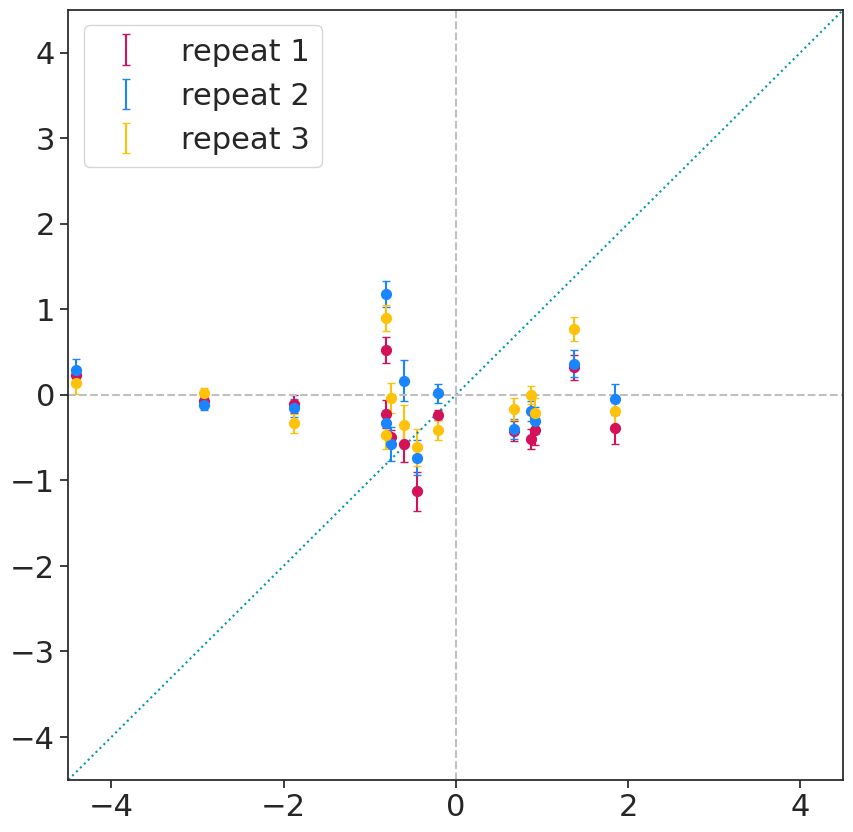

In [100]:
plt.figure(figsize=(10, 10))
sns.set(context="notebook", palette="colorblind", style="ticks", font_scale=2)
colours = ["#D41159", "#1A85FF", "#FFC20A"]
labels = ["repeat 1", "repeat 2", "repeat 3"]
for i in range(len(repeat_differences)):
    plt.scatter(experimental_free_energies, repeat_differences[i], s=50, color=colours[i])
    # plt.scatter(3, 2.5, s=0)

    (_, caps, _) = plt.errorbar(experimental_free_energies,
                            repeat_differences[i],
                            color=colours[i],
                            yerr=repeat_errors[i],
                            capsize=3,
                            linestyle="",
                            zorder=-1, label=labels[i])

plt.legend()

plt.plot([-4.5, 4.5], [-4.5, 4.5], color="#0099AB", linestyle=":", zorder=-1)
plt.vlines(0, -4.5, 4.5, color = "silver", linestyle="--", zorder=-1)
plt.hlines(0, -4.5, 4.5, color = "silver", linestyle="--", zorder=-1)
plt.xlim(-4.5, 4.5)
plt.ylim(-4.5, 4.5)

In [98]:
pearson_r = scipy.stats.pearsonr(experimental_free_energies, avg_differences)
pearson_r

PearsonRResult(statistic=-0.14100400008994154, pvalue=0.6306486661243781)